# Minimal Signal Comparison: Fourier Series Model

Compare classical guitar audio with the Fourier series resonator model:

$$
f(t) = \sum_{n=0}^{\infty} A_n \cos\left(n\omega_0 t + \phi_n\right) + \sum_{n=0}^{\infty} \alpha_n A_n \cos\left(n\omega_0 t + \phi_n + \theta\right)
$$

## Mathematical Model Terms

**Variables:**
- \( t \) - Time (seconds)

**Parameters:**
- \( \omega_0 = \frac{2\pi}{T} = 2\pi f_0 \) - Fundamental frequency in rad/s
  - \( T \) is the period, \( f_0 \) is the fundamental frequency in Hz
  - Represents the base frequency of the signal

- \( n \) - Harmonic index (0, 1, 2, 3, ...)
  - \( n=0 \): DC component
  - \( n=1 \): Fundamental frequency
  - \( n=2,3,4,... \): Harmonics (2×f₀, 3×f₀, 4×f₀, ...)

**Coefficients:**
- \( A_n \) - Amplitude coefficient for the \( n \)-th harmonic
  - Controls the strength of each harmonic component
  - Extracted from the input signal or set manually

- \( \phi_n \) - Phase coefficient for the \( n \)-th harmonic (radians)
  - Controls the phase offset of each harmonic
  - Extracted from the input signal or set manually

- \( \alpha_n \) - Frequency-dependent amplitude scaling factor for the \( n \)-th harmonic
  - Models the resonator's response at different frequencies
  - Typically larger for frequencies in the sasando range (98-1047 Hz)
  - This is what makes the model frequency-dependent

- \( \theta \) - Phase shift introduced by the resonator (radians)
  - Constant phase shift applied to the second series
  - Models the phase delay introduced by the resonator

**Two Series:**
1. **First sum**: \( \sum_{n=0}^{\infty} A_n \cos(n\omega_0 t + \phi_n) \)
   - Represents the original signal decomposed into harmonics

2. **Second sum**: \( \sum_{n=0}^{\infty} \alpha_n A_n \cos(n\omega_0 t + \phi_n + \theta) \)
   - Represents the resonator's contribution
   - Each harmonic is scaled by \( \alpha_n \) and phase-shifted by \( \theta \)


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq
from pathlib import Path

try:
    import librosa
except ImportError:
    print("Install librosa: pip install librosa")

plt.rcParams['figure.figsize'] = (16, 8)


In [26]:
def load_audio(file_path):
    """Load audio file (.m4a, .wav, .mp3, .csv)"""
    file_path = Path(file_path)
    
    # Try different path resolutions
    if file_path.is_absolute():
        resolved_path = file_path
    else:
        # Try relative to current directory
        if file_path.exists():
            resolved_path = file_path
        # Try relative to ryan_files/ (notebook location)
        elif (Path('ryan_files') / file_path).exists():
            resolved_path = Path('ryan_files') / file_path
        # Try from project root if we're in ryan_files/
        elif Path.cwd().name == 'ryan_files' and (Path('..') / file_path).exists():
            resolved_path = Path('..') / file_path
        else:
            # Last attempt: try ryan_files/Data/...
            alt_path = Path('ryan_files') / file_path
            if alt_path.exists():
                resolved_path = alt_path
            else:
                resolved_path = file_path  # Will raise error below
    
    # Convert to absolute path to avoid working directory issues
    resolved_path = resolved_path.resolve()
    
    if not resolved_path.exists():
        raise FileNotFoundError(f"Audio file not found: {file_path}\nTried: {resolved_path}")
    
    if resolved_path.suffix.lower() == '.csv':
        data = np.genfromtxt(resolved_path, delimiter=',', skip_header=1)
        time = data[:, 0] / 1000.0 if np.max(data[:, 0]) > 1000 else data[:, 0]
        amplitude = data[:, 1]
        if np.max(np.abs(amplitude)) > 0:
            amplitude = amplitude / np.max(np.abs(amplitude))
        sample_rate = 1.0 / (time[1] - time[0])
    else:
        # Use absolute path string for librosa
        amplitude, sample_rate = librosa.load(str(resolved_path), sr=None, mono=True)
        time = np.arange(len(amplitude)) / sample_rate
    
    return time, amplitude, sample_rate


In [27]:
def process_fourier_series(signal, sample_rate, time,
                           omega_0=None, num_harmonics=20,
                           A_n=None, phi_n=None, alpha_n=None, theta=0.0):
    """
    Process signal using Fourier series model:
    f(t) = Σ A_n cos(nω₀t + φ_n) + Σ α_n A_n cos(nω₀t + φ_n + θ)
    
    If A_n and phi_n are provided as arrays, they are used directly.
    If None, they are extracted from the input signal.
    """
    # FFT of input (only needed if A_n/phi_n not provided)
    fft_signal = rfft(signal)
    freqs = rfftfreq(len(signal), 1/sample_rate)
    magnitude = np.abs(fft_signal)
    phase = np.angle(fft_signal)
    
    # Estimate fundamental if not provided
    if omega_0 is None:
        mask = (freqs >= 20) & (freqs <= 2000)
        if np.any(mask):
            peak_idx = np.argmax(magnitude[mask])
            omega_0 = 2 * np.pi * freqs[mask][peak_idx]
        else:
            omega_0 = 2 * np.pi * 261.63
    
    f0_hz = omega_0 / (2 * np.pi)
    
    def get_coeff(coeff, n, default):
        if coeff is None:
            return default(n) if callable(default) else default
        elif isinstance(coeff, (list, np.ndarray)):
            if n < len(coeff):
                return coeff[n]
            return 0.0
        elif callable(coeff):
            return coeff(n)
        else:
            return coeff
    
    processed = np.zeros_like(signal)
    
    # Check if A_n and phi_n are provided as arrays (extracted features)
    use_extracted = (isinstance(A_n, (list, np.ndarray)) and 
                     isinstance(phi_n, (list, np.ndarray)) and
                     len(A_n) >= num_harmonics and len(phi_n) >= num_harmonics)
    
    for n in range(num_harmonics):
        if use_extracted:
            # Use extracted features directly
            A = A_n[n]
            phi = phi_n[n]
        else:
            # Extract from signal
            target_freq = n * f0_hz
            if target_freq <= freqs[-1]:
                idx = np.argmin(np.abs(freqs - target_freq))
                A_input = magnitude[idx] / len(signal)
                phi_input = phase[idx]
                
                A_coeff = get_coeff(A_n, n, lambda n: 1.0)
                phi_coeff = get_coeff(phi_n, n, lambda n: 0.0)
                
                A = A_input * A_coeff
                phi = phi_input + phi_coeff
            else:
                A = 0.0
                phi = 0.0
        
        # Get alpha_n (resonator response)
        alpha = get_coeff(alpha_n, n, lambda n: 0.5)
        
        # First series: A_n cos(nω₀t + φ_n)
        processed += A * np.cos(n * omega_0 * time + phi)
        
        # Second series: α_n A_n cos(nω₀t + φ_n + θ)
        processed += alpha * A * np.cos(n * omega_0 * time + phi + theta)
    
    # Normalize to match original signal's amplitude characteristics
    # Use RMS scaling for better energy matching, especially with limited harmonics
    if np.max(np.abs(processed)) > 0 and np.max(np.abs(signal)) > 0:
        # Calculate RMS for both signals
        rms_signal = np.sqrt(np.mean(signal**2))
        rms_processed = np.sqrt(np.mean(processed**2))
        
        if rms_processed > 0:
            # Scale by RMS ratio to match energy level
            processed = processed * (rms_signal / rms_processed)
        
        # Also ensure peak doesn't exceed original's peak
        max_signal = np.max(np.abs(signal))
        max_processed = np.max(np.abs(processed))
        if max_processed > max_signal and max_processed > 0:
            # Scale down if peak is too high
            processed = processed * (max_signal / max_processed)
    elif np.max(np.abs(processed)) > 0:
        # If original signal has zero amplitude, just normalize processed
        processed = processed / np.max(np.abs(processed))
    
    return processed


## Configuration


In [28]:
# Audio file path (relative to notebook location in ryan_files/)
AUDIO_FILE = "Data/classical guitar/C_classical_1.m4a"

# Fourier series parameters
NUM_HARMONICS = 5  # Number of harmonics (n = 0, 1, 2, 3, 4)
THETA = np.pi / 4  # Phase shift (radians) - resonator phase delay

# Load classical guitar audio
print(f"Loading classical guitar: {AUDIO_FILE}")
time, amplitude_classical, sample_rate = load_audio(AUDIO_FILE)

# Extract features directly from the classical guitar signal
print("\nExtracting features from classical guitar signal...")
fft_classical = rfft(amplitude_classical)
freqs_classical = rfftfreq(len(amplitude_classical), 1/sample_rate)
magnitude_classical = np.abs(fft_classical)
phase_classical = np.angle(fft_classical)

# Estimate fundamental frequency
mask = (freqs_classical >= 20) & (freqs_classical <= 2000)
if np.any(mask):
    peak_idx = np.argmax(magnitude_classical[mask])
    estimated_f0 = freqs_classical[mask][peak_idx]
    omega_0 = 2 * np.pi * estimated_f0
else:
    estimated_f0 = 261.63
    omega_0 = 2 * np.pi * estimated_f0

print(f"Classical guitar - Sample rate: {sample_rate:.1f} Hz, Duration: {time[-1]:.2f}s")
print(f"Estimated fundamental frequency: {estimated_f0:.2f} Hz (ω₀ = {omega_0:.2f} rad/s)")

# Extract A_n and φ_n directly from the signal for each harmonic
# FFT magnitude scaling: For real signals, the amplitude is 2*magnitude/N for n>0, magnitude/N for n=0
A_n_extracted = []
phi_n_extracted = []

for n in range(NUM_HARMONICS):
    target_freq = n * estimated_f0
    if target_freq <= freqs_classical[-1]:
        idx = np.argmin(np.abs(freqs_classical - target_freq))
        # Proper FFT scaling for time-domain reconstruction
        if n == 0:
            # DC component: magnitude / N
            A_n = magnitude_classical[idx] / len(amplitude_classical)
        else:
            # Harmonic components: 2 * magnitude / N (for real signals)
            A_n = 2 * magnitude_classical[idx] / len(amplitude_classical)
        phi_n = phase_classical[idx]
        A_n_extracted.append(A_n)
        phi_n_extracted.append(phi_n)
    else:
        A_n_extracted.append(0.0)
        phi_n_extracted.append(0.0)

print(f"\nExtracted {NUM_HARMONICS} harmonics:")
for n in range(NUM_HARMONICS):
    freq = n * estimated_f0
    print(f"  n={n}: f={freq:.2f} Hz, A_n={A_n_extracted[n]:.6f}, φ_n={phi_n_extracted[n]:.4f} rad")

# Define alpha_n function (resonator response - still configurable)
def alpha_n_func(n):
    freq_hz = n * estimated_f0
    # Boost frequencies in sasando range (98-1047 Hz)
    return 0.8 if 98 <= freq_hz <= 1047 else 0.2

# Use extracted features directly (no generic functions)
# Convert to arrays for the processing function
A_n_array = np.array(A_n_extracted)
phi_n_array = np.array(phi_n_extracted)

print("\nProcessing signal with Fourier series model using extracted features...")
amplitude_fourier_model = process_fourier_series(
    amplitude_classical, sample_rate, time,
    omega_0=omega_0,  # Use extracted fundamental
    num_harmonics=NUM_HARMONICS,
    A_n=A_n_array,      # Use extracted amplitudes directly
    phi_n=phi_n_array,  # Use extracted phases directly
    alpha_n=alpha_n_func,  # Still use function for resonator response
    theta=THETA
)

# Diagnostic: Check amplitude ranges
print(f"\nAmplitude diagnostics:")
print(f"  Classical guitar - Max: {np.max(np.abs(amplitude_classical)):.6f}, RMS: {np.sqrt(np.mean(amplitude_classical**2)):.6f}")
print(f"  Fourier model - Max: {np.max(np.abs(amplitude_fourier_model)):.6f}, RMS: {np.sqrt(np.mean(amplitude_fourier_model**2)):.6f}")
print(f"  Ratio (Fourier/Classical max): {np.max(np.abs(amplitude_fourier_model)) / np.max(np.abs(amplitude_classical)):.2f}")

print("\n✓ Fourier series model processing complete")
print("   Model now uses features extracted directly from classical guitar signal")


Loading classical guitar: Data/classical guitar/C_classical_1.m4a

Extracting features from classical guitar signal...
Classical guitar - Sample rate: 48000.0 Hz, Duration: 7.68s
Estimated fundamental frequency: 131.14 Hz (ω₀ = 823.99 rad/s)

Extracted 5 harmonics:
  n=0: f=0.00 Hz, A_n=0.000001, φ_n=0.0000 rad
  n=1: f=131.14 Hz, A_n=0.023864, φ_n=2.3672 rad
  n=2: f=262.29 Hz, A_n=0.009990, φ_n=1.6944 rad
  n=3: f=393.43 Hz, A_n=0.007728, φ_n=-2.2550 rad
  n=4: f=524.57 Hz, A_n=0.000241, φ_n=-0.1830 rad

Processing signal with Fourier series model using extracted features...

Amplitude diagnostics:
  Classical guitar - Max: 0.297745, RMS: 0.041081
  Fourier model - Max: 0.062162, RMS: 0.041081
  Ratio (Fourier/Classical max): 0.21

✓ Fourier series model processing complete
   Model now uses features extracted directly from classical guitar signal


/var/folders/2h/t411d17d6jj2cw0g5vgr_jn80000gn/T/ipykernel_39848/3990230237.py:41: UserWarning: PySoundFile failed. Trying audioread instead.
  amplitude, sample_rate = librosa.load(str(resolved_path), sr=None, mono=True)


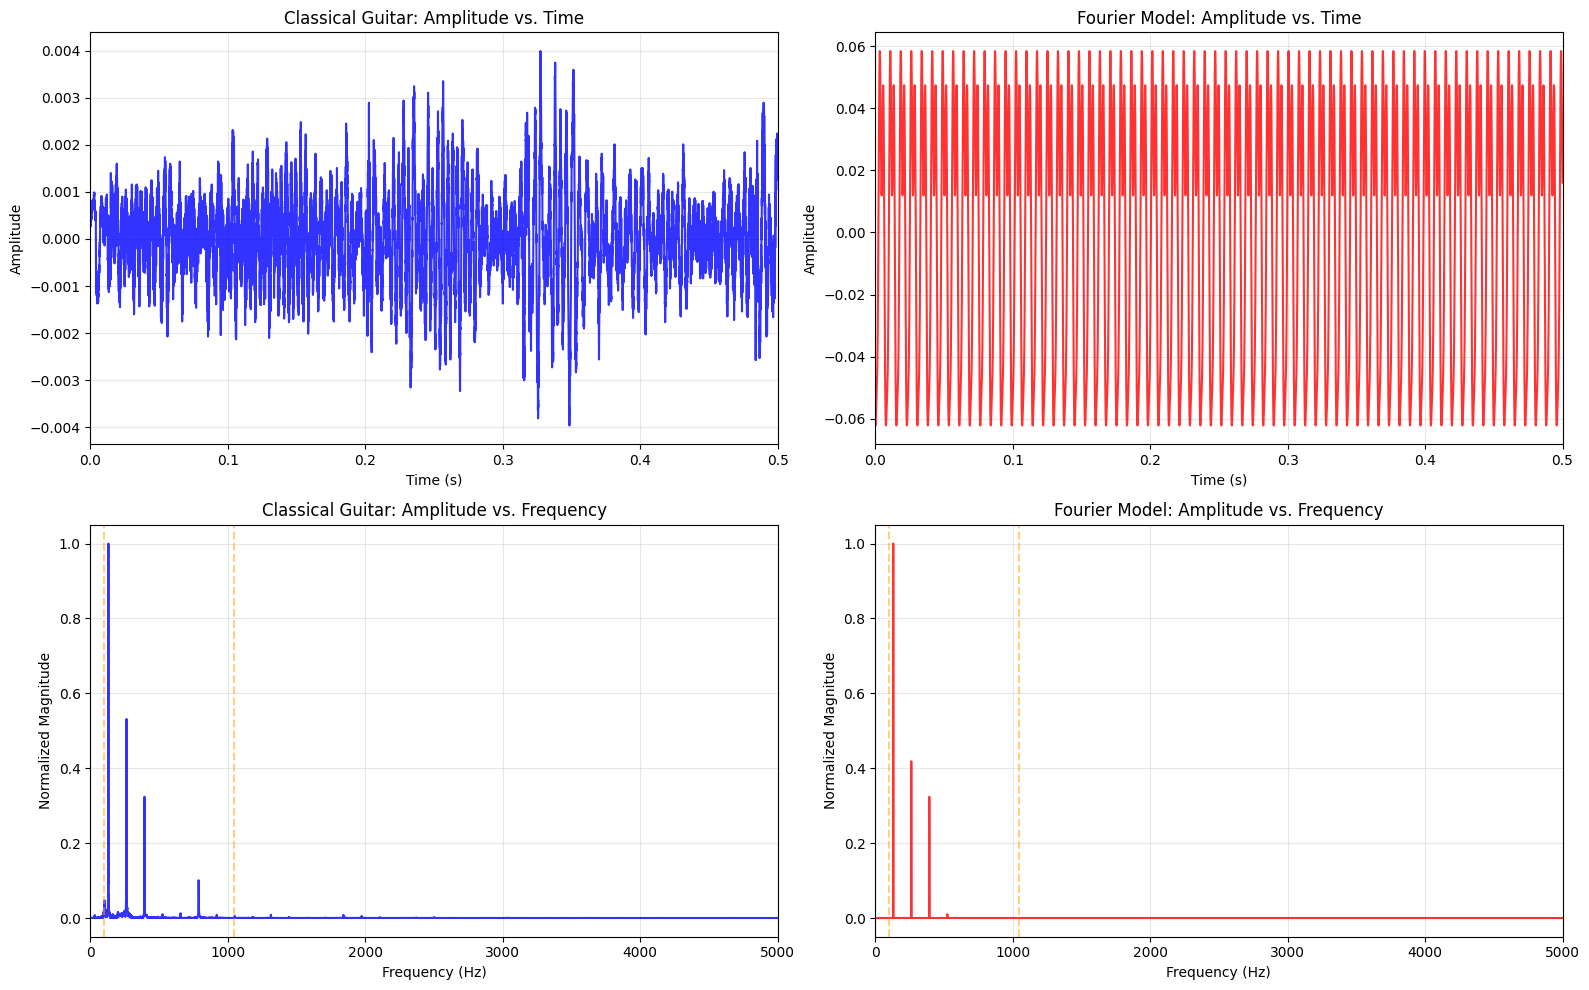

In [29]:
# Compute FFT for comparison
fft_classical = rfft(amplitude_classical)
fft_fourier = rfft(amplitude_fourier_model)
freqs = rfftfreq(len(amplitude_classical), 1/sample_rate)
mag_classical = np.abs(fft_classical)
mag_fourier = np.abs(fft_fourier)
mag_classical_norm = mag_classical / np.max(mag_classical) if np.max(mag_classical) > 0 else mag_classical
mag_fourier_norm = mag_fourier / np.max(mag_fourier) if np.max(mag_fourier) > 0 else mag_fourier

# Time window
t_window = min(0.5, time[-1])
t_mask = time <= t_window
freq_mask = freqs <= 5000

# Plot
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Top Left: Classical Guitar - Time
axes[0, 0].plot(time[t_mask], amplitude_classical[t_mask], 'b-', linewidth=1.5, alpha=0.8)
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('Amplitude')
axes[0, 0].set_title('Classical Guitar: Amplitude vs. Time')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xlim([0, t_window])

# Top Right: Fourier Model - Time
axes[0, 1].plot(time[t_mask], amplitude_fourier_model[t_mask], 'r-', linewidth=1.5, alpha=0.8)
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('Amplitude')
axes[0, 1].set_title('Fourier Model: Amplitude vs. Time')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xlim([0, t_window])

# Bottom Left: Classical Guitar - Frequency
axes[1, 0].plot(freqs[freq_mask], mag_classical_norm[freq_mask], 'b-', linewidth=1.5, alpha=0.8)
axes[1, 0].set_xlabel('Frequency (Hz)')
axes[1, 0].set_ylabel('Normalized Magnitude')
axes[1, 0].set_title('Classical Guitar: Amplitude vs. Frequency')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xlim([0, 5000])
axes[1, 0].axvline(98, color='orange', linestyle='--', alpha=0.5, label='Sasando range')
axes[1, 0].axvline(1047, color='orange', linestyle='--', alpha=0.5)

# Bottom Right: Fourier Model - Frequency
axes[1, 1].plot(freqs[freq_mask], mag_fourier_norm[freq_mask], 'r-', linewidth=1.5, alpha=0.8)
axes[1, 1].set_xlabel('Frequency (Hz)')
axes[1, 1].set_ylabel('Normalized Magnitude')
axes[1, 1].set_title('Fourier Model: Amplitude vs. Frequency')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xlim([0, 5000])
axes[1, 1].axvline(98, color='orange', linestyle='--', alpha=0.5, label='Sasando range')
axes[1, 1].axvline(1047, color='orange', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


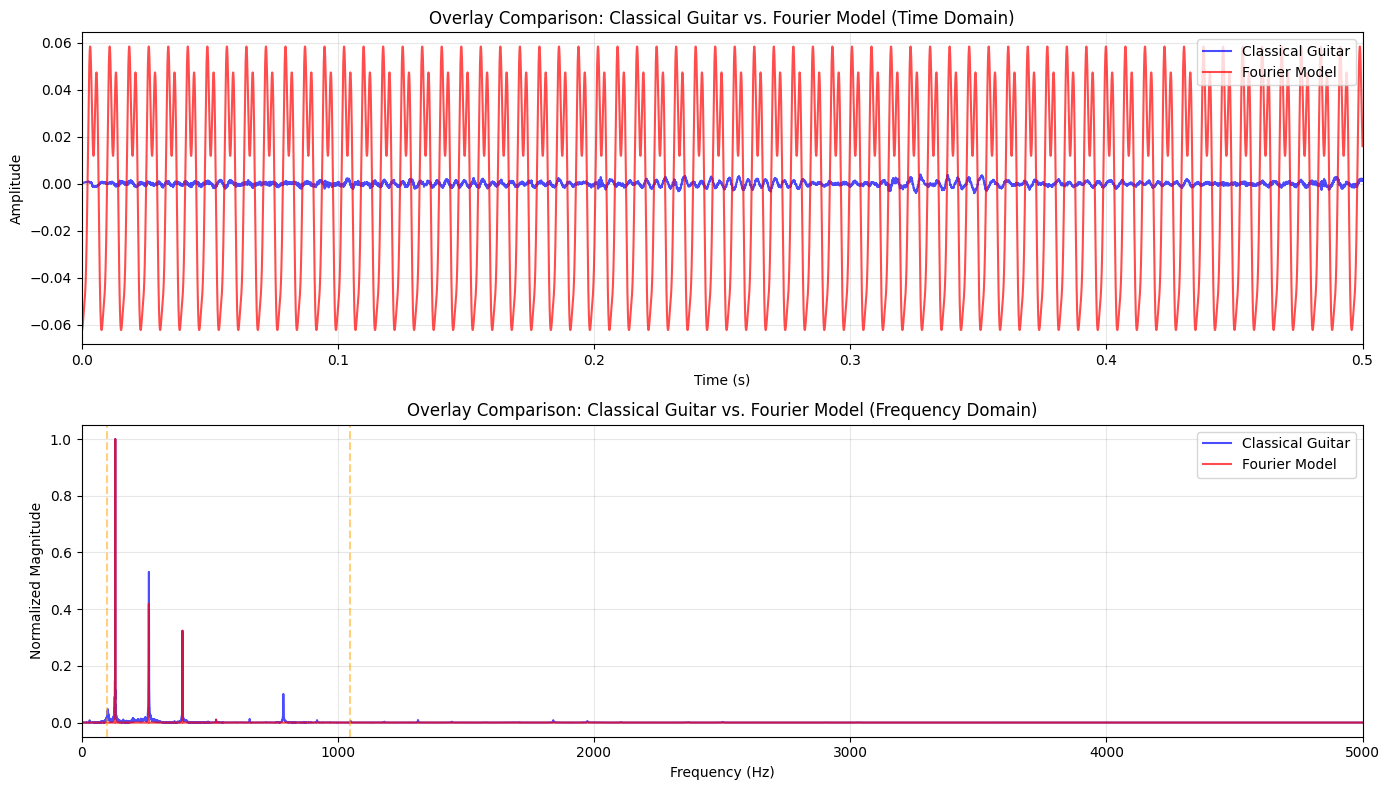

In [30]:
# Overlay comparison: Classical Guitar vs. Fourier Model
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Time domain overlay
axes[0].plot(time[t_mask], amplitude_classical[t_mask], 'b-', linewidth=1.5, label='Classical Guitar', alpha=0.7)
axes[0].plot(time[t_mask], amplitude_fourier_model[t_mask], 'r-', linewidth=1.5, label='Fourier Model', alpha=0.7)
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Overlay Comparison: Classical Guitar vs. Fourier Model (Time Domain)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, t_window])

# Frequency domain overlay
axes[1].plot(freqs[freq_mask], mag_classical_norm[freq_mask], 'b-', linewidth=1.5, label='Classical Guitar', alpha=0.7)
axes[1].plot(freqs[freq_mask], mag_fourier_norm[freq_mask], 'r-', linewidth=1.5, label='Fourier Model', alpha=0.7)
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Normalized Magnitude')
axes[1].set_title('Overlay Comparison: Classical Guitar vs. Fourier Model (Frequency Domain)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, 5000])
axes[1].axvline(98, color='orange', linestyle='--', alpha=0.5, label='Sasando range (98-1047 Hz)')
axes[1].axvline(1047, color='orange', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
